In [1]:
from climada.entity import Exposures

In [37]:
import geopandas as gpd
import pandas as pd

#update with the path on your computer
sites = pd.read_excel("whc-sites-2021.xlsx")

In [3]:
sites # we read the excel sheet as a "pandas" dataframe, which allows you to work with tables

,unique_number,id_no,rev_bis,name_en,name_fr,short_description_en,short_description_fr,justification_en,justification_fr,date_inscribed,...,criteria_txt,category,category_short,states_name_en,states_name_fr,region_en,region_fr,iso_code,udnp_code,transboundary
0,230.0,208.0,Rev,Cultural Landscape and Archaeological Remains ...,Paysage culturel et vestiges archéologiques de...,<p>The cultural landscape and archaeological r...,<p>Le paysage culturel et les vestiges archéol...,<p><em>Criterion (i):</em> The Buddha statues ...,<p><em>Critère (i):</em> Les statues de Bouddh...,2003.0,...,(i)(ii)(iii)(iv)(vi),Cultural,C,Afghanistan,Afghanistan,Asia and the Pacific,Asie et Pacifique,af,afg,0.0
1,234.0,211.0,Rev,Minaret and Archaeological Remains of Jam,Minaret et vestiges archéologiques de Djam,"<p>The 65m-tall Minaret of Jam is a graceful, ...","<p>Haut de 65m, le minaret de Djam est une con...",<p><em>Criterion (ii):</em> The innovative arc...,<p><em>Critère (ii)</em> : L'architecture et l...,2002.0,...,(ii)(iii)(iv),Cultural,C,Afghanistan,Afghanistan,Asia and the Pacific,Asie et Pacifique,af,afg,0.0
2,1590.0,569.0,Bis,Historic Centres of Berat and Gjirokastra,Centres historiques de Berat et de Gjirokastra,<p>Berat and Gjirokastra are inscribed as rare...,<p>Berat et Gjirokastra sont inscrites en tant...,NaN,NaN,2005.0,...,(iii)(iv),Cultural,C,Albania,Albanie,Europe and North America,Europe et Amérique du Nord,al,alb,0.0
3,1563.0,570.0,ter,Butrint,Butrint,"<p>Inhabited since prehistoric times, Butrint ...","<p>Habité depuis les temps préhistoriques, le ...",NaN,NaN,1992.0,...,(iii),Cultural,C,Albania,Albanie,Europe and North America,Europe et Amérique du Nord,al,alb,0.0
4,111.0,102.0,NaN,Al Qal'a of Beni Hammad,La Kalâa des Béni Hammad,<p>In a mountainous site of extraordinary beau...,<p>Dans un site montagneux d&rsquo;une saisiss...,NaN,NaN,1980.0,...,(iii),Cultural,C,Algeria,Algérie,Arab States,États arabes,dz,dza,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,2150.0,1448.0,NaN,Landscapes of Dauria,Paysages de la Dauria,<p>Shared between Mongolia and the Russian Fed...,<p>Partagé entre la Fédération de Russie et la...,NaN,NaN,2017.0,...,(ix)(x),Natural,N,"Mongolia,Russian Federation","Fédération de Russie,Mongolie","Asia and the Pacific,Europe and North America","Asie et Pacifique,Europe et Amérique du Nord","mn,ru","mng,rus",1.0
1151,1894.0,1424.0,NaN,Wooden <em>Tserkvas</em> of the Carpathian Reg...,<em>Tserkvas</em> en bois de la région des Car...,<p>Situated in the eastern fringe of Central E...,<p>Situ&eacute; aux confins orientaux de l&rsq...,NaN,NaN,2013.0,...,(iii)(iv),Cultural,C,"Poland,Ukraine","Pologne,Ukraine",Europe and North America,Europe et Amérique du Nord,"pl,ua","pol,ukr",1.0
1152,1642.0,866.0,Bis,Prehistoric Rock Art Sites in the Côa Valley a...,Sites d’art rupestre préhistorique de la vallé...,<p>The two Prehistoric Rock Art Sites in the C...,<p>Les sites d'art rupestre préhistorique de l...,NaN,NaN,1998.0,...,(i)(iii),Cultural,C,"Portugal,Spain","Espagne,Portugal",Europe and North America,Europe et Amérique du Nord,"es,pt","esp,prt",1.0
1153,1841.0,1313.0,Rev,Heritage of Mercury. Almadén and Idrija,Patrimoine du mercure. Almadén et Idrija,<p>The property includes the mining sites of A...,<p>Le bien inclut les sites miniers d'Almad&ea...,NaN,NaN,2012.0,...,(ii)(iv),Cultural,C,"Slovenia,Spain","Espagne,Slovénie",Europe and North America,Europe et Amérique du Nord,"es,si","esp,svn",1.0


In [4]:
# now we make a "geodataframe", it is similar to a pandas dataframe but it is able to work with geolocalisation 
crs = {'init': 'epsg:4326'}
sites = gpd.GeoDataFrame(
    sites, geometry=gpd.points_from_xy(sites.longitude, sites.latitude)) 

In [5]:
# here you can see that we added a "geometry" column
sites 

,unique_number,id_no,rev_bis,name_en,name_fr,short_description_en,short_description_fr,justification_en,justification_fr,date_inscribed,...,category,category_short,states_name_en,states_name_fr,region_en,region_fr,iso_code,udnp_code,transboundary,geometry
0,230.0,208.0,Rev,Cultural Landscape and Archaeological Remains ...,Paysage culturel et vestiges archéologiques de...,<p>The cultural landscape and archaeological r...,<p>Le paysage culturel et les vestiges archéol...,<p><em>Criterion (i):</em> The Buddha statues ...,<p><em>Critère (i):</em> Les statues de Bouddh...,2003.0,...,Cultural,C,Afghanistan,Afghanistan,Asia and the Pacific,Asie et Pacifique,af,afg,0.0,POINT (67.82525 34.84694)
1,234.0,211.0,Rev,Minaret and Archaeological Remains of Jam,Minaret et vestiges archéologiques de Djam,"<p>The 65m-tall Minaret of Jam is a graceful, ...","<p>Haut de 65m, le minaret de Djam est une con...",<p><em>Criterion (ii):</em> The innovative arc...,<p><em>Critère (ii)</em> : L'architecture et l...,2002.0,...,Cultural,C,Afghanistan,Afghanistan,Asia and the Pacific,Asie et Pacifique,af,afg,0.0,POINT (64.51606 36.39656)
2,1590.0,569.0,Bis,Historic Centres of Berat and Gjirokastra,Centres historiques de Berat et de Gjirokastra,<p>Berat and Gjirokastra are inscribed as rare...,<p>Berat et Gjirokastra sont inscrites en tant...,NaN,NaN,2005.0,...,Cultural,C,Albania,Albanie,Europe and North America,Europe et Amérique du Nord,al,alb,0.0,POINT (20.14083 40.07417)
3,1563.0,570.0,ter,Butrint,Butrint,"<p>Inhabited since prehistoric times, Butrint ...","<p>Habité depuis les temps préhistoriques, le ...",NaN,NaN,1992.0,...,Cultural,C,Albania,Albanie,Europe and North America,Europe et Amérique du Nord,al,alb,0.0,POINT (20.02095 39.74573)
4,111.0,102.0,NaN,Al Qal'a of Beni Hammad,La Kalâa des Béni Hammad,<p>In a mountainous site of extraordinary beau...,<p>Dans un site montagneux d&rsquo;une saisiss...,NaN,NaN,1980.0,...,Cultural,C,Algeria,Algérie,Arab States,États arabes,dz,dza,0.0,POINT (4.78684 35.81844)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,2150.0,1448.0,NaN,Landscapes of Dauria,Paysages de la Dauria,<p>Shared between Mongolia and the Russian Fed...,<p>Partagé entre la Fédération de Russie et la...,NaN,NaN,2017.0,...,Natural,N,"Mongolia,Russian Federation","Fédération de Russie,Mongolie","Asia and the Pacific,Europe and North America","Asie et Pacifique,Europe et Amérique du Nord","mn,ru","mng,rus",1.0,POINT (115.42544 49.93022)
1151,1894.0,1424.0,NaN,Wooden <em>Tserkvas</em> of the Carpathian Reg...,<em>Tserkvas</em> en bois de la région des Car...,<p>Situated in the eastern fringe of Central E...,<p>Situ&eacute; aux confins orientaux de l&rsq...,NaN,NaN,2013.0,...,Cultural,C,"Poland,Ukraine","Pologne,Ukraine",Europe and North America,Europe et Amérique du Nord,"pl,ua","pol,ukr",1.0,POINT (21.03222 49.53389)
1152,1642.0,866.0,Bis,Prehistoric Rock Art Sites in the Côa Valley a...,Sites d’art rupestre préhistorique de la vallé...,<p>The two Prehistoric Rock Art Sites in the C...,<p>Les sites d'art rupestre préhistorique de l...,NaN,NaN,1998.0,...,Cultural,C,"Portugal,Spain","Espagne,Portugal",Europe and North America,Europe et Amérique du Nord,"es,pt","esp,prt",1.0,POINT (-6.66111 40.69750)
1153,1841.0,1313.0,Rev,Heritage of Mercury. Almadén and Idrija,Patrimoine du mercure. Almadén et Idrija,<p>The property includes the mining sites of A...,<p>Le bien inclut les sites miniers d'Almad&ea...,NaN,NaN,2012.0,...,Cultural,C,"Slovenia,Spain","Espagne,Slovénie",Europe and North America,Europe et Amérique du Nord,"es,si","esp,svn",1.0,POINT (-4.83889 38.77528)


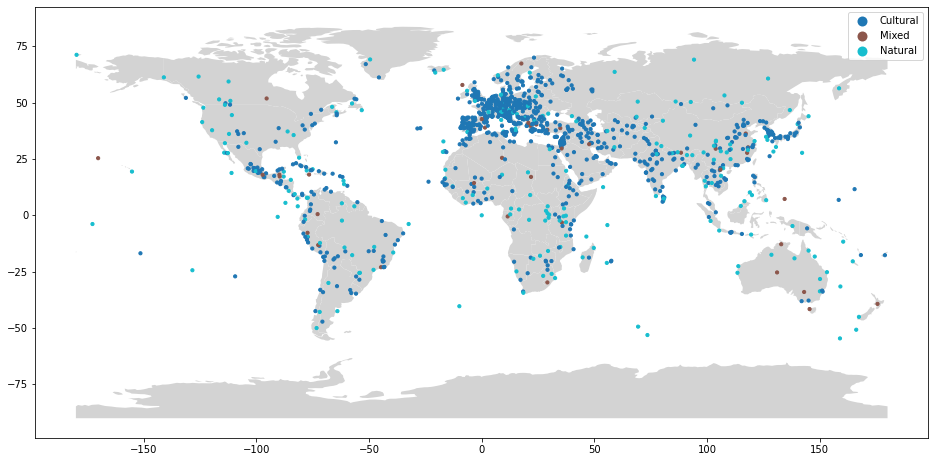

In [6]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(figsize=(16, 12))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(color='lightgray', ax=axis)
sites.plot('category', ax=axis, categorical=True,
             markersize=10, legend=True)
fig.savefig('map_cutural_sites.pdf')

In [7]:
sites = sites[sites.category=='Cultural'] # here I am selecting only cultural sites, if you skip this you would do the analyssis for all sites

In [8]:
exposures = Exposures() # now we want to create an Exposure object from climada, which will allow us to calculate impacts
exposures.gdf = sites

In [9]:
from climada.util.api_client import Client # this is the climada api client, which allows to get data for hazards
from pathlib import Path

In [10]:
#this takes a while, the file is about 1.3gb and needs to be downloaded
client = Client()
tc_present = client.get_hazard('tropical_cyclone', properties={'spatial_coverage':'global', 'climate_scenario':'historical'})

https://climada.ethz.ch/data-api/v1/dataset	climate_scenario=historical	data_type=tropical_cyclone	limit=100000	name=None	spatial_coverage=global	status=active	version=None


In [47]:
Client.purge_cache(Path("/Users/szelie/climada/data/hazard/earthquake/earthquake_hist_world_above4/v1/earthquake_hist_world_above4.hdf5"))


In [48]:
#this takes a while, the file is about 1.3gb and needs to be downloaded
client = Client()
earthquake = client.get_hazard('earthquake', properties={'spatial_coverage':'global'}, status='preliminary')

https://climada.ethz.ch/data-api/v1/dataset	data_type=earthquake	limit=100000	name=None	spatial_coverage=global	status=preliminary	version=None
2022-09-27 12:06:47,706 - climada.util.api_client - WARNING - Download failed: /Users/szelie/climada/data/hazard/earthquake/earthquake_hist_world_above4/v1/earthquake_hist_world_above4.hdf5 has the wrong size:2724295915 instead of 2736261402, retrying...


In [50]:
earthquake

In [ ]:
#also this takes some time
#tc_present.plot_intensity(0)

In [11]:
hist_events = [event for event in tc_present.event_name if 'gen' not in event]

In [14]:
tc_hist = tc_present.select(event_names=hist_events)

In [15]:
exposures.assign_centroids(tc_hist)

2022-09-27 09:42:30,920 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 93 coordinates.


2022-09-27 12:23:33,140 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 93 coordinates.


/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_54218/566840243.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(figsize=(5,3))


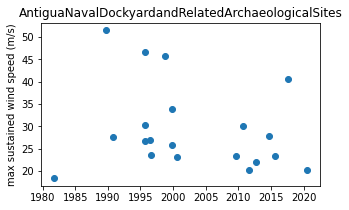

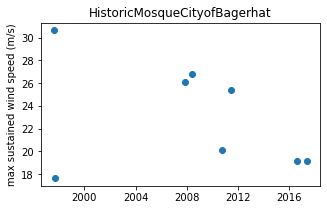

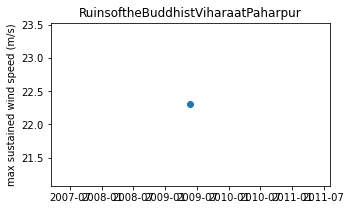

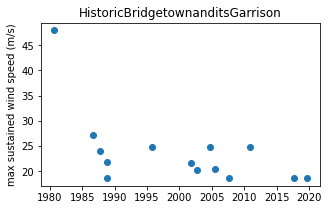

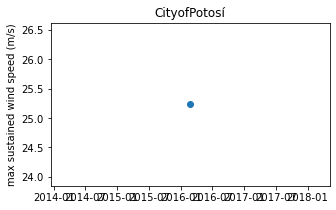

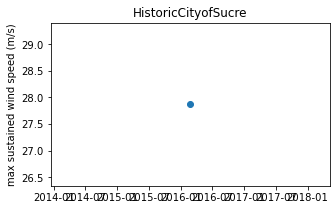

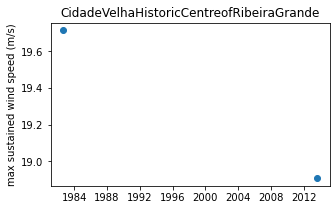

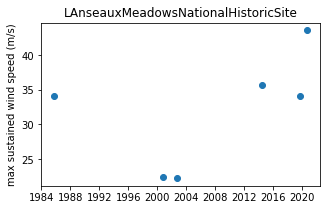

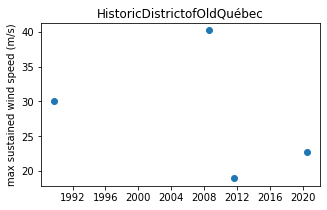

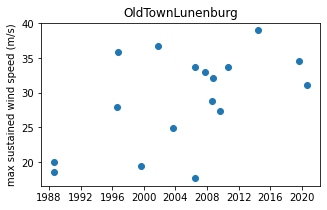

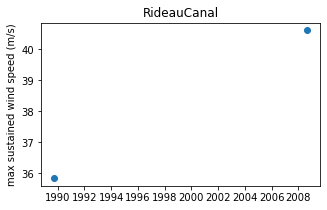

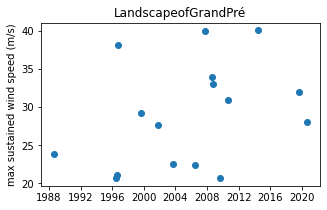

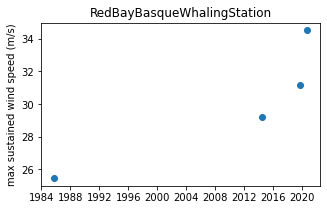

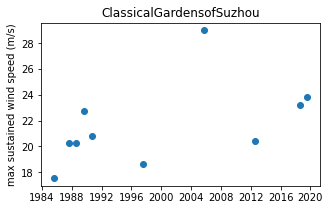

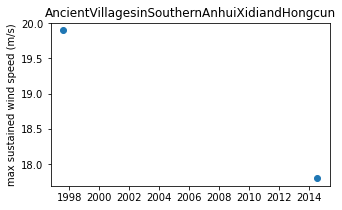

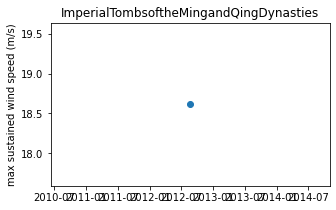

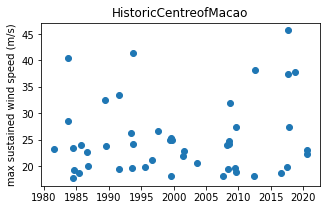

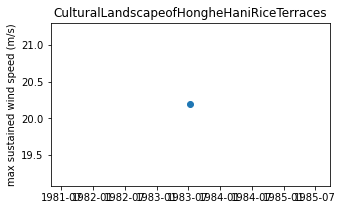

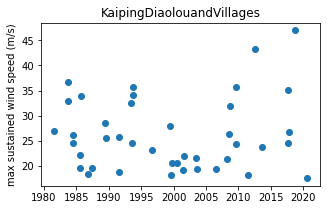

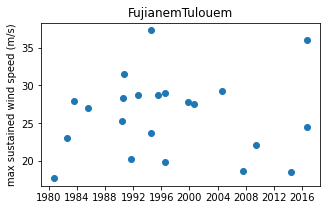

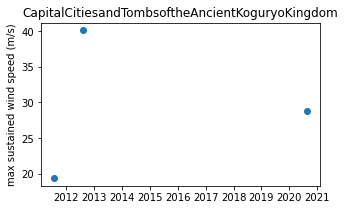

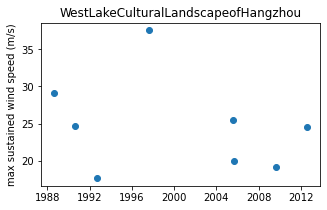

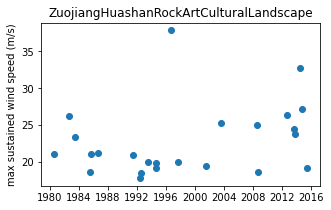

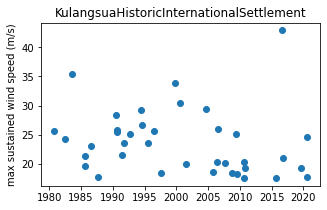

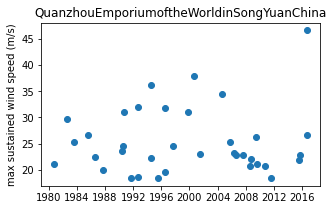

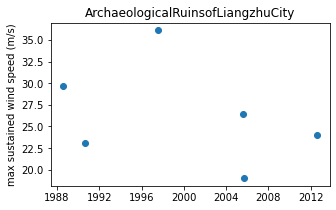

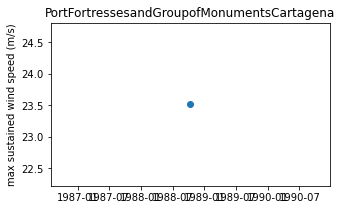

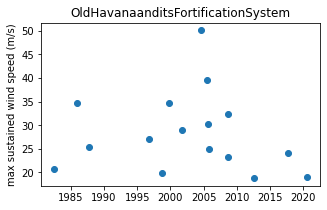

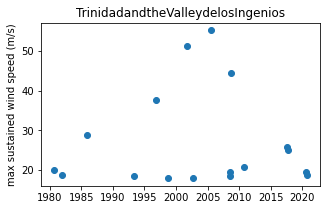

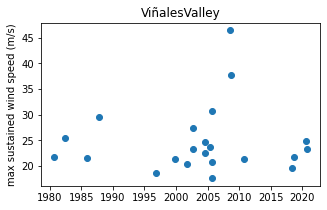

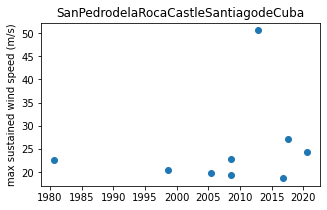

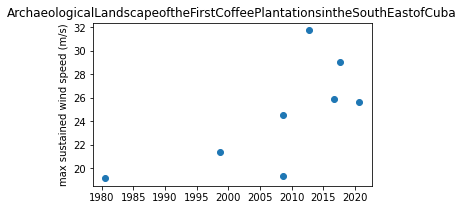

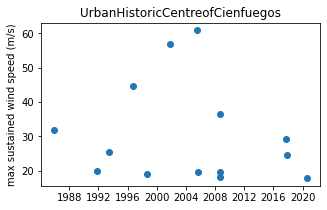

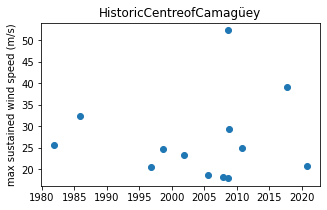

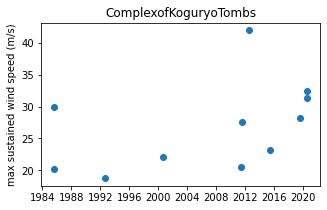

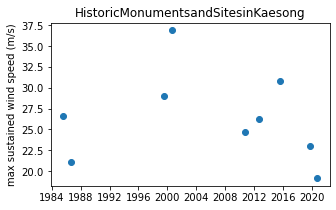

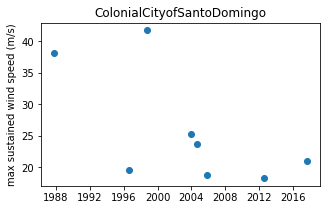

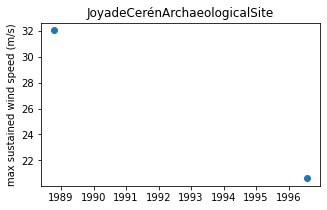

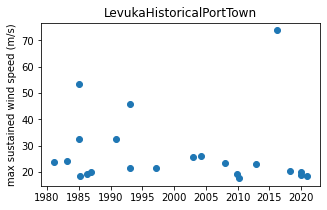

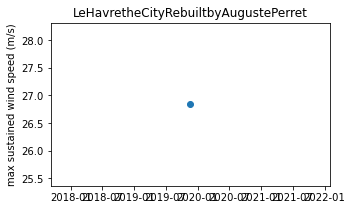

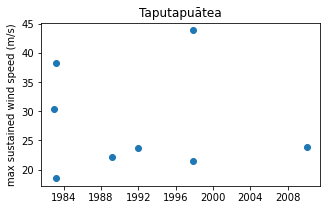

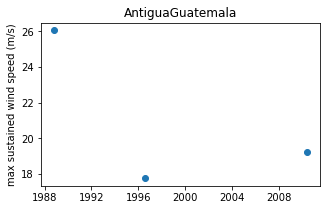

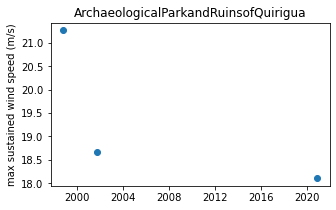

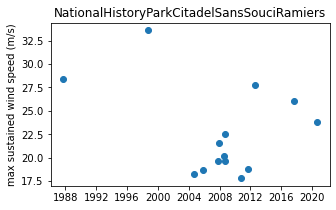

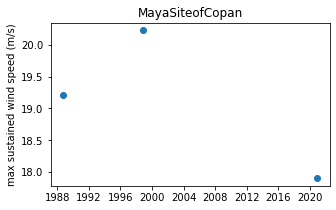

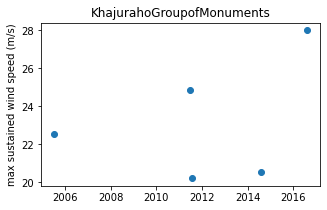

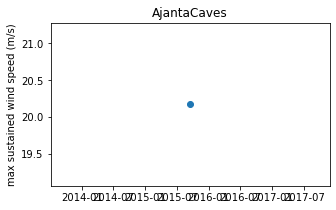

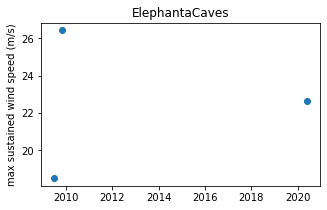

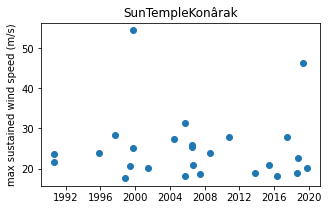

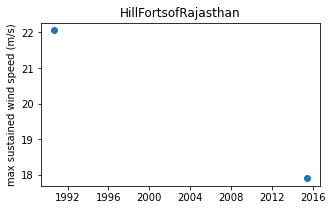

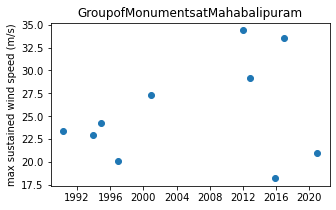

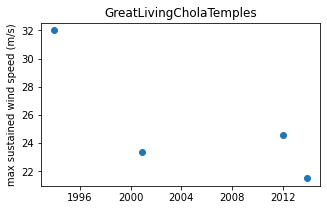

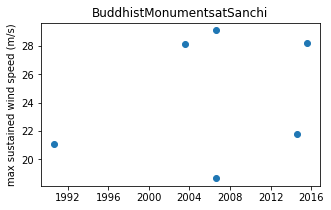

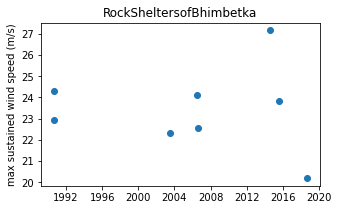

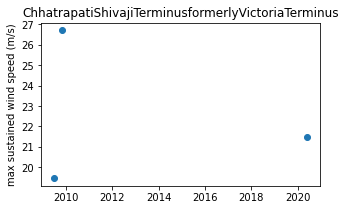

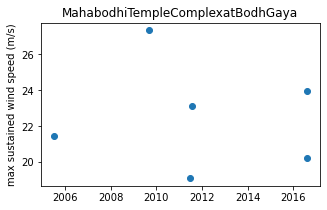

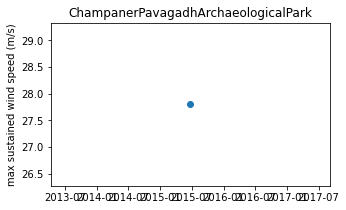

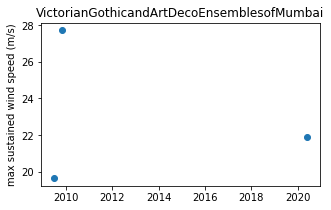

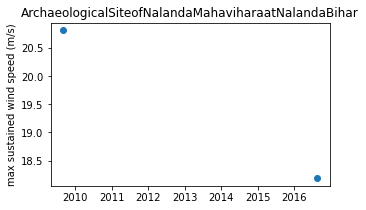

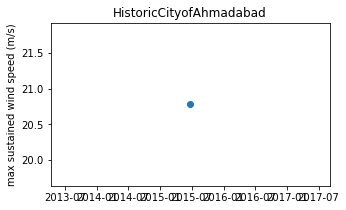

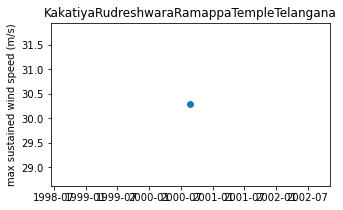

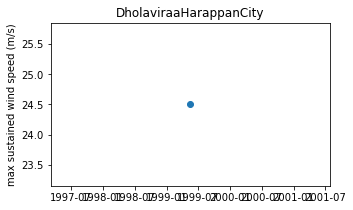

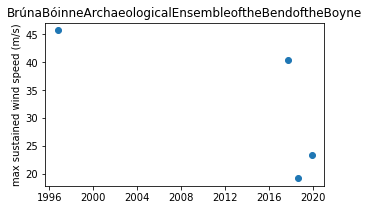

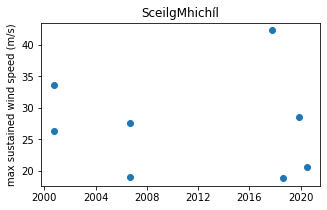

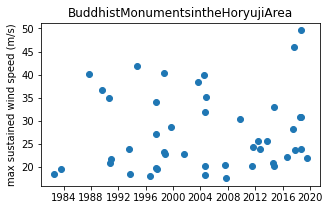

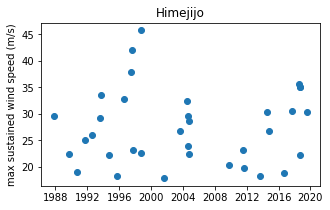

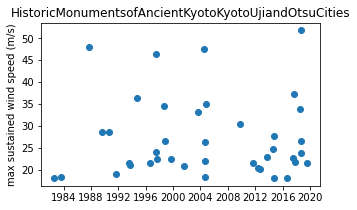

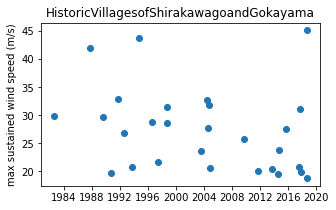

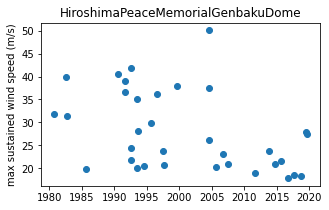

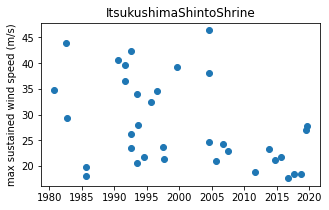

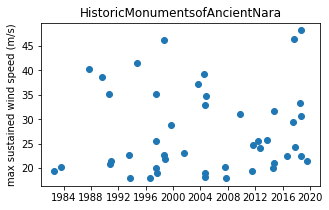

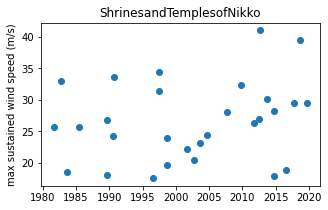

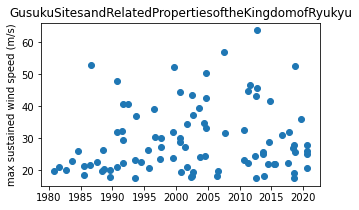

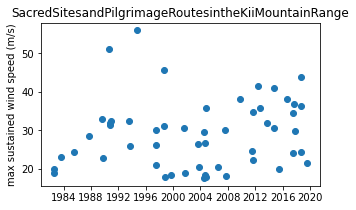

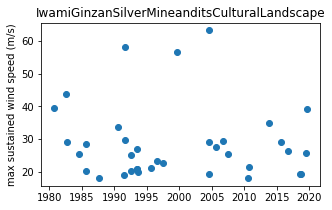

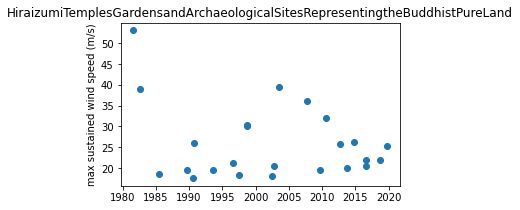

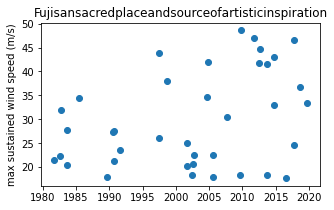

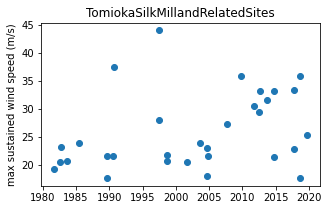

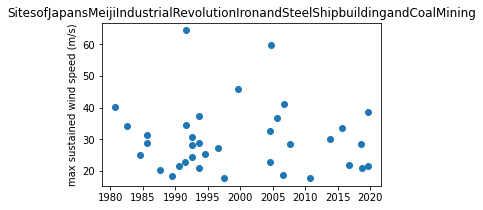

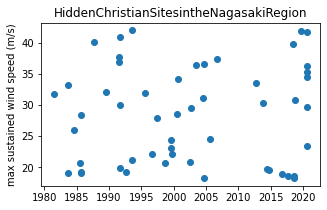

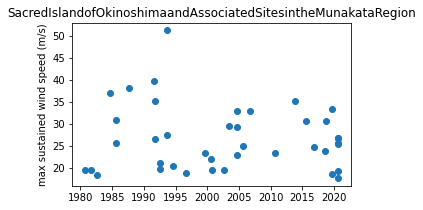

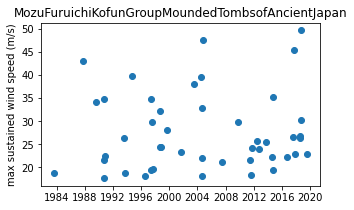

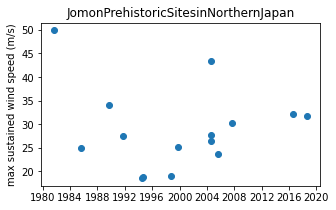

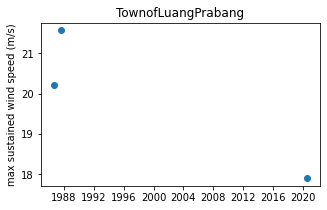

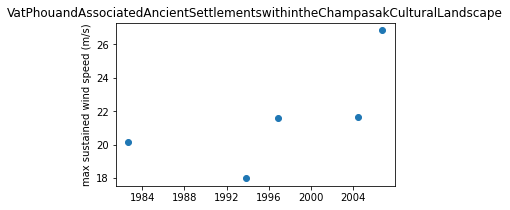

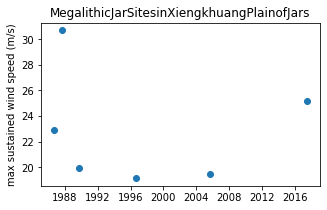

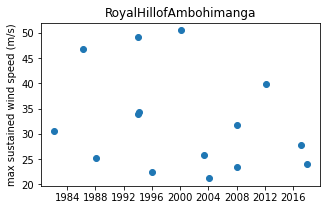

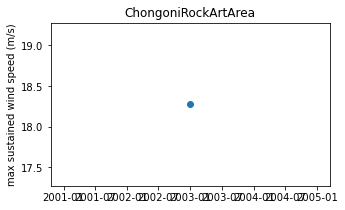

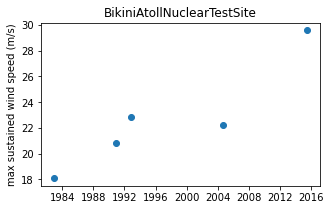

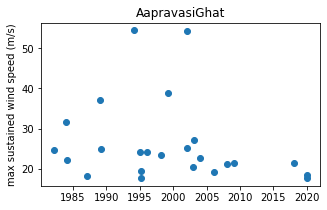

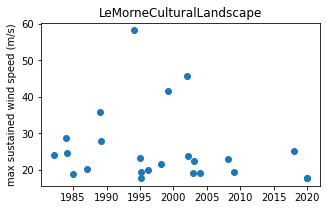

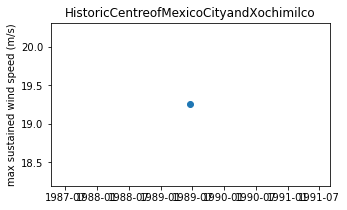

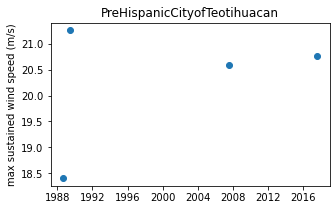

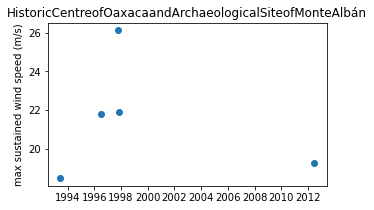

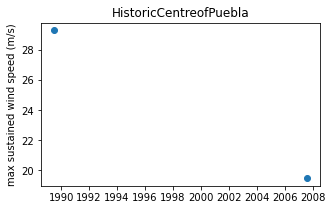

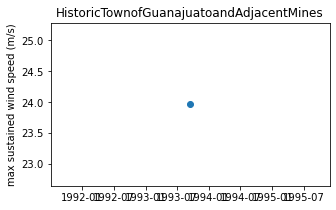

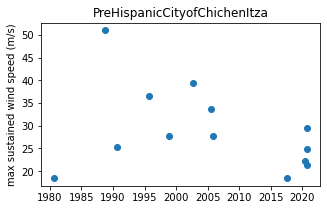

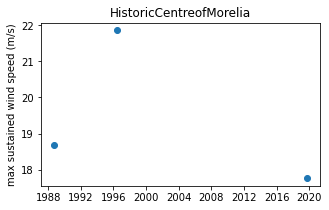

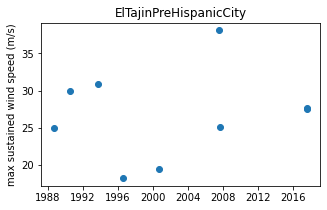

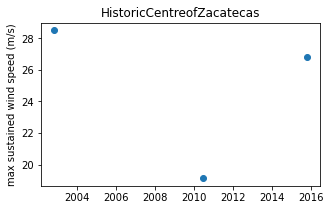

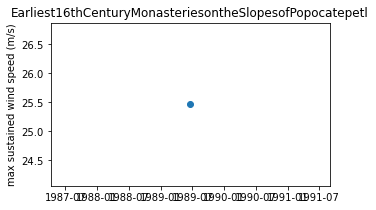

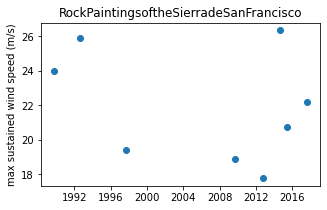

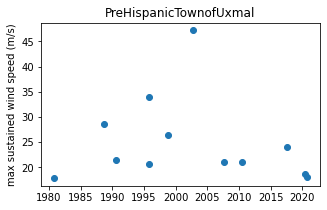

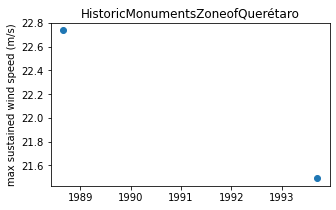

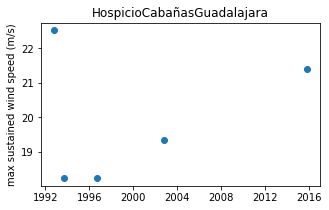

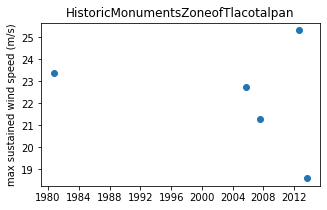

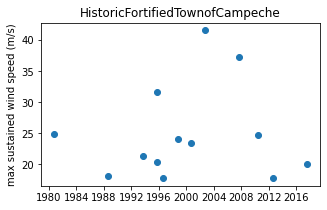

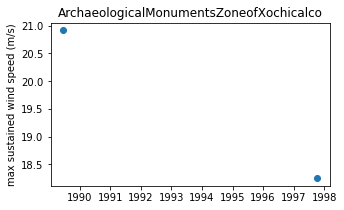

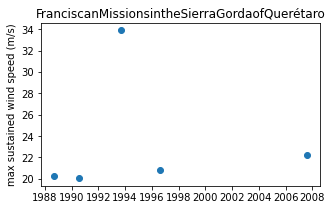

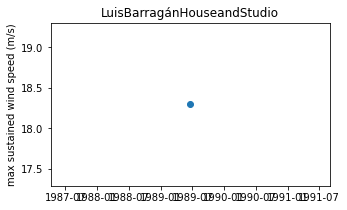

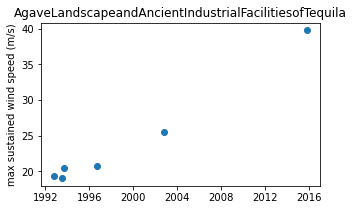

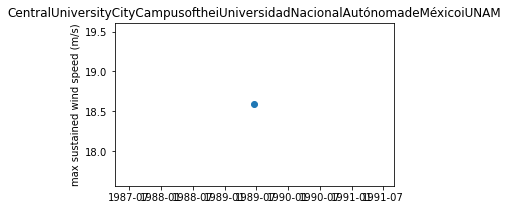

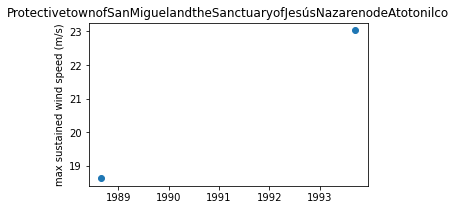

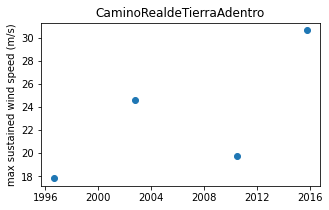

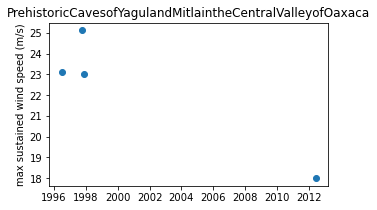

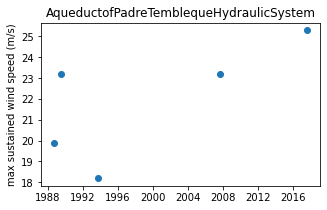

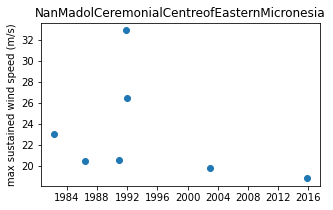

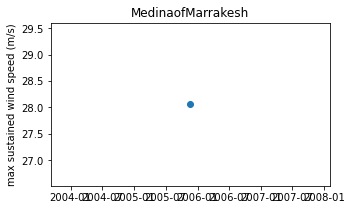

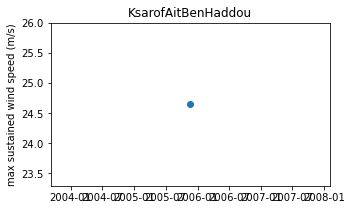

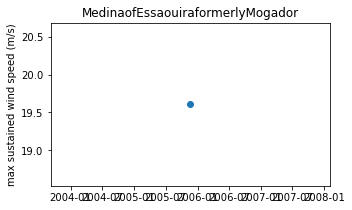

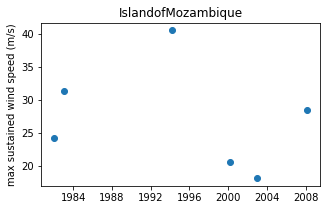

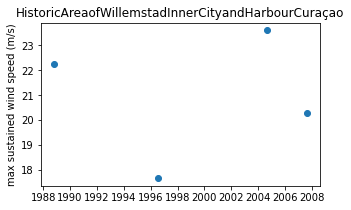

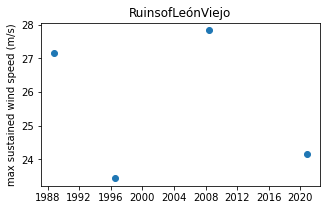

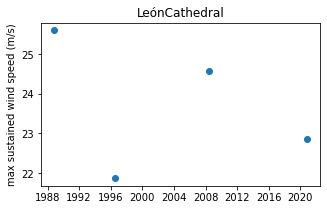

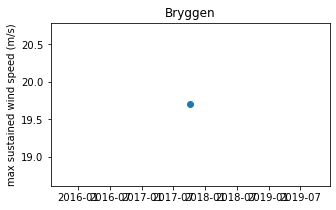

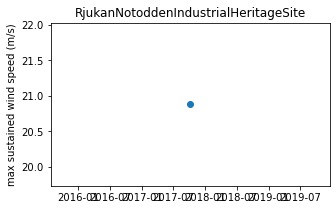

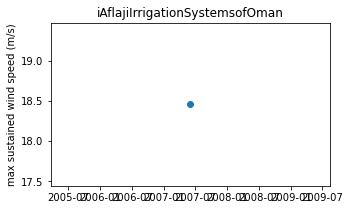

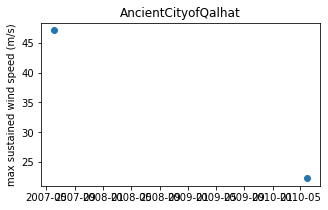

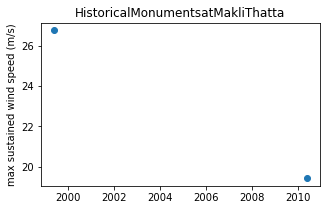

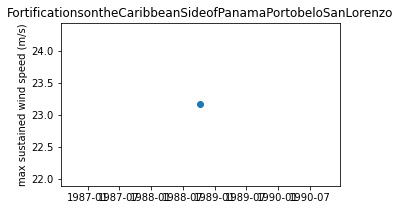

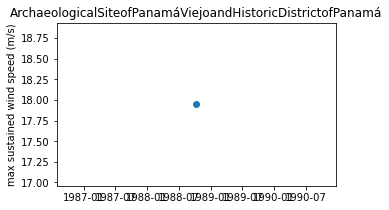

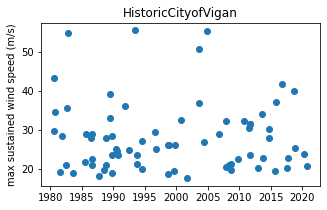

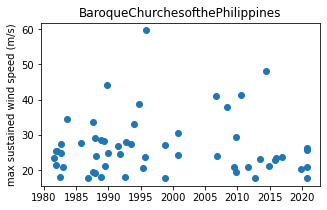

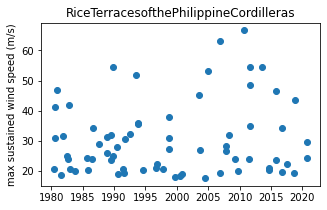

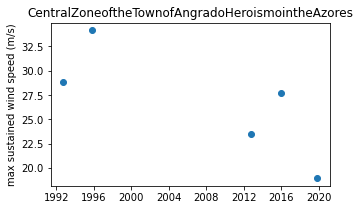

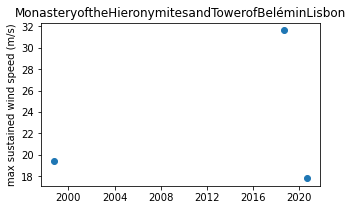

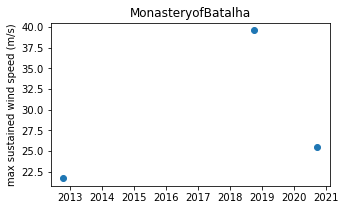

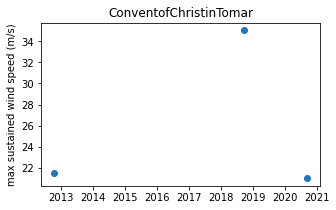

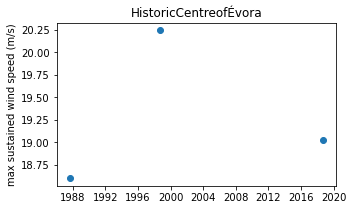

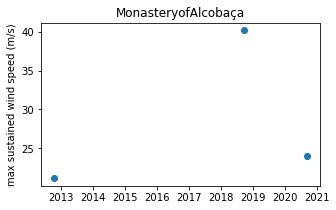

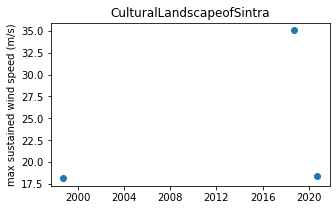

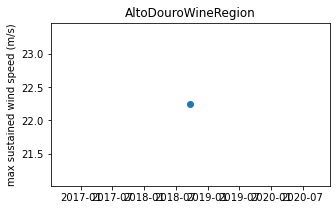

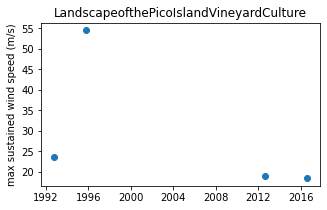

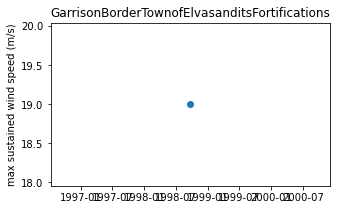

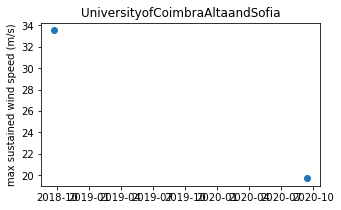

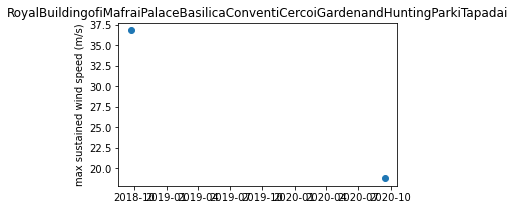

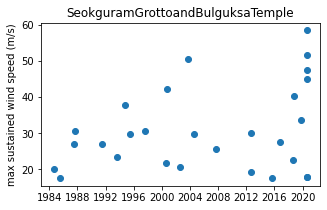

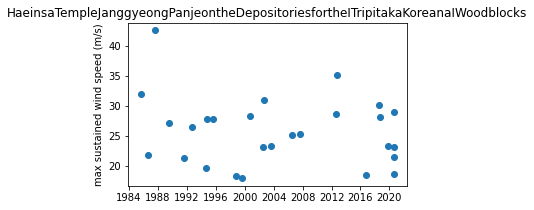

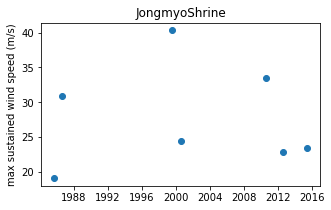

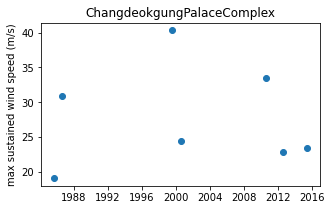

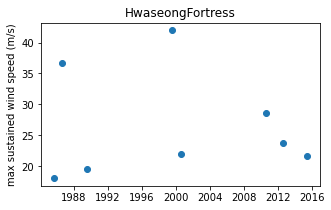

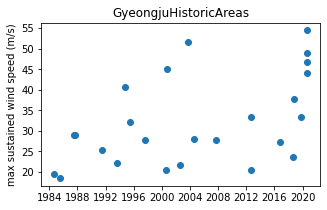

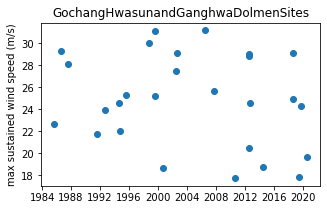

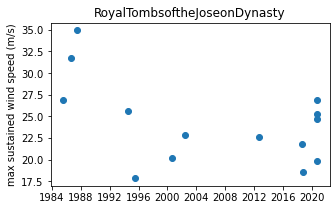

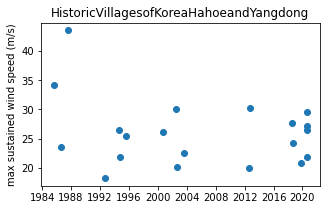

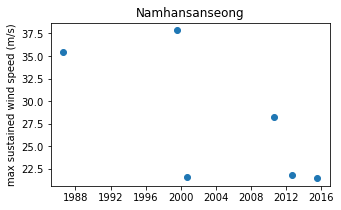

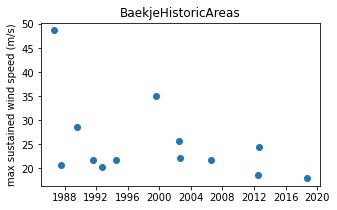

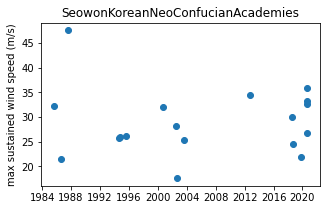

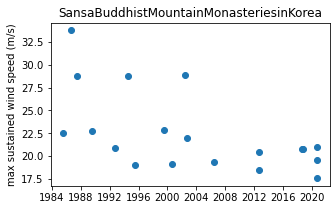

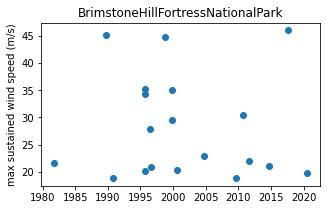

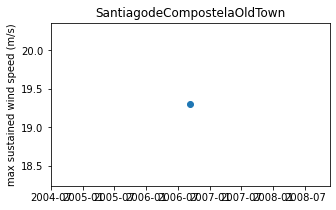

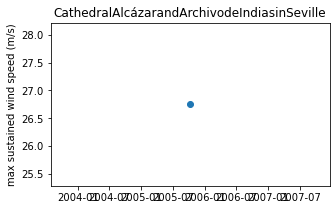

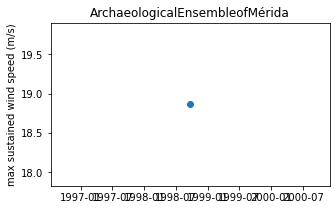

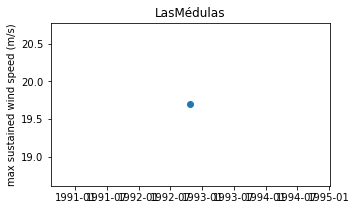

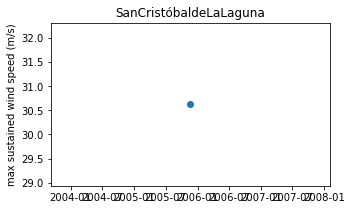

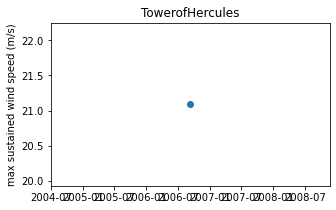

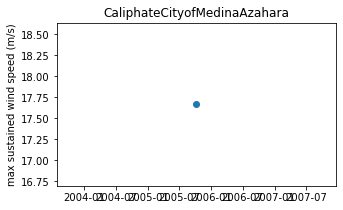

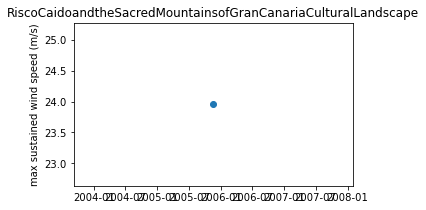

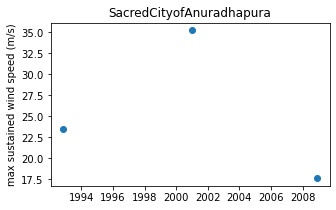

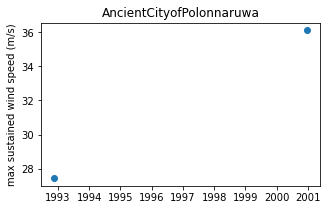

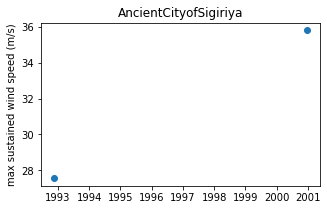

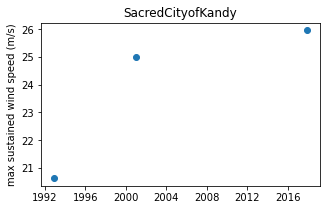

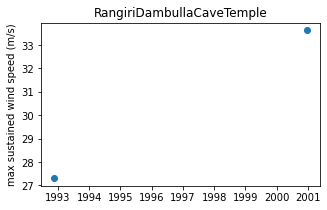

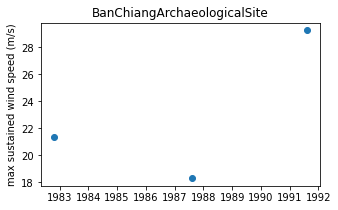

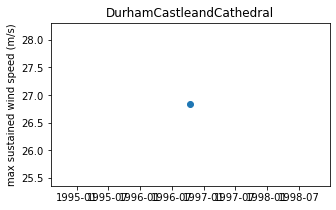

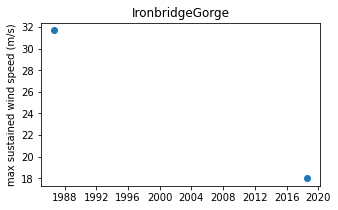

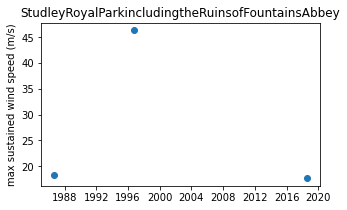

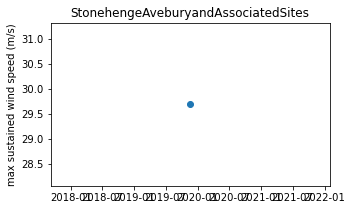

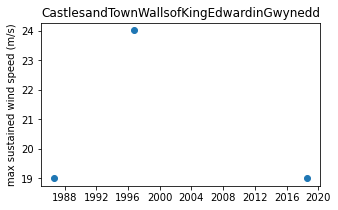

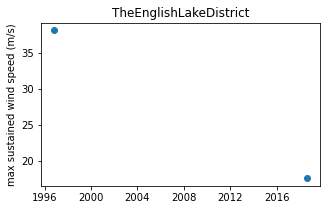

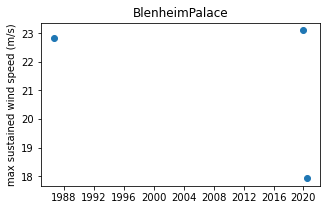

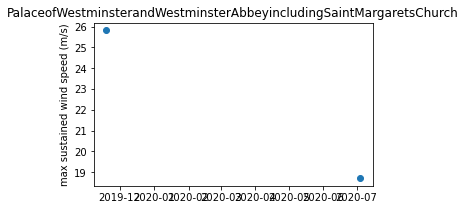

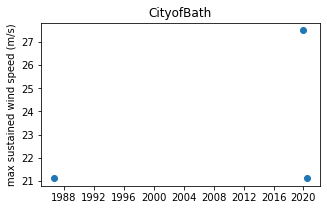

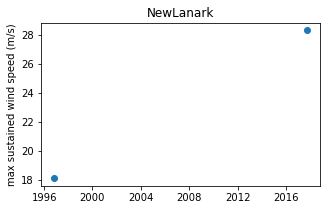

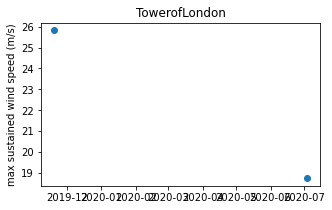

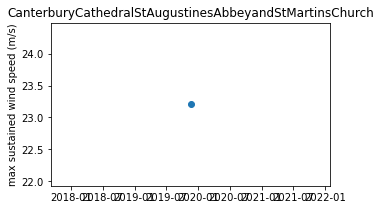

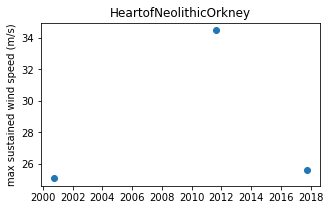

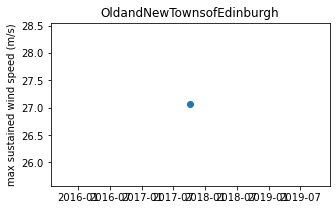

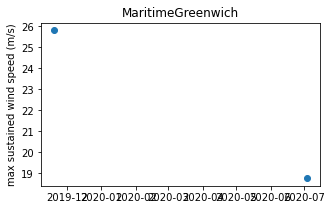

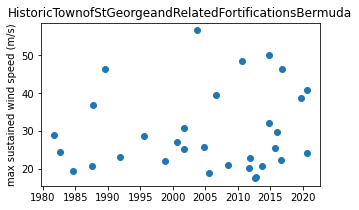

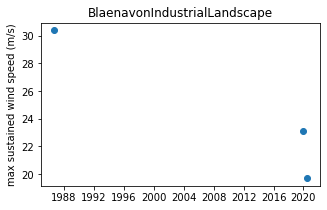

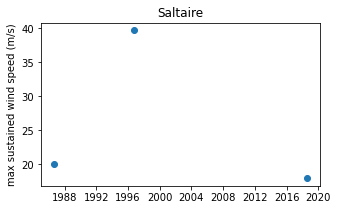

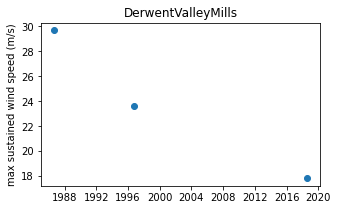

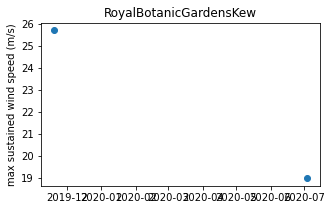

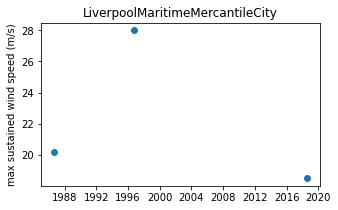

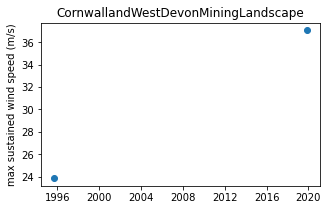

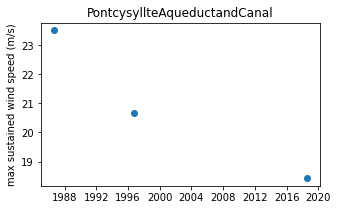

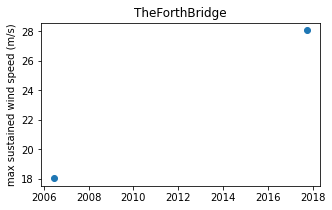

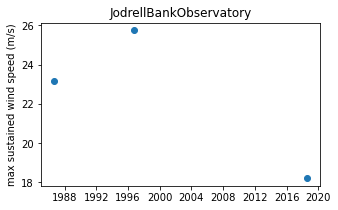

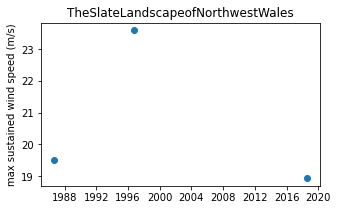

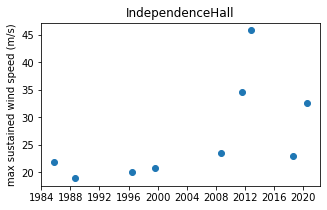

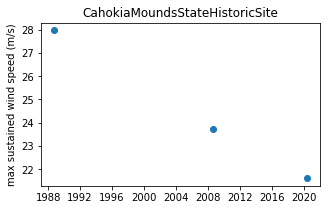

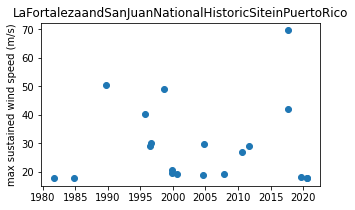

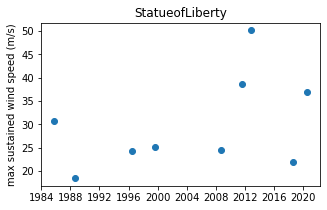

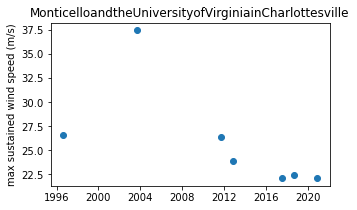

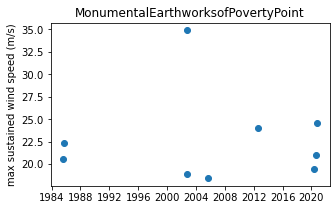

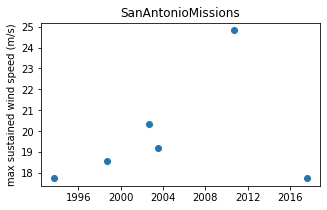

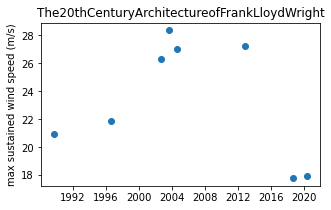

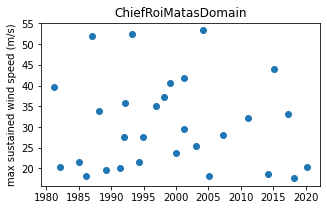

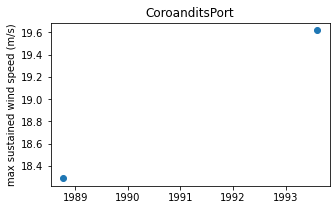

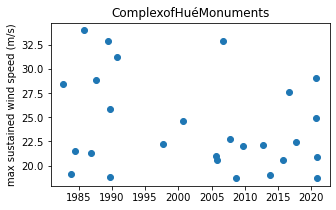

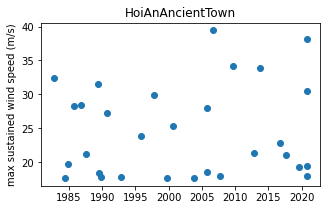

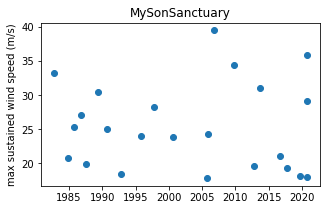

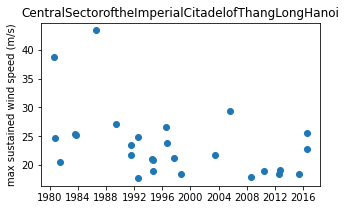

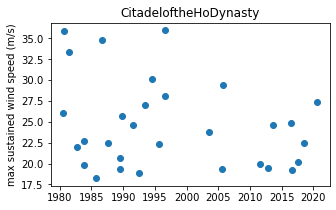

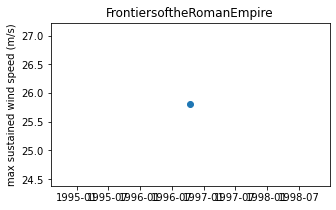

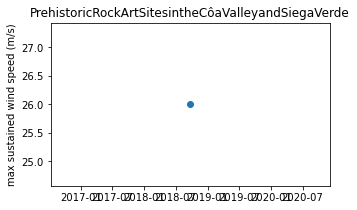

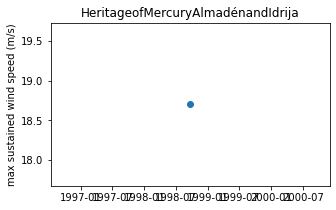

In [61]:
import datetime
import copy

exposures.assign_centroids(tc_hist)
sites = exposures.gdf
list_df = []

for site in sites.index:    
    centroid = sites.loc[site]['centr_TC']
    nonzero = tc_hist.intensity[:,centroid].nonzero()
    if tc_hist.intensity.nnz==0:
        continue
    intensity_site = tc_hist.intensity[nonzero[0],centroid]
    tc_date = tc_hist.date[nonzero[0]]
    tc_date = [datetime.date.fromordinal(date) for date in tc_date]
    site_name = exposures.gdf.loc[site]['name_en']
    site_name = ''.join(e for e in site_name if e.isalnum())
    intensity_site = intensity_site.toarray().flatten()
    
    if len(intensity_site)>0:
        fig,ax = plt.subplots(figsize=(5,3))
        ax.scatter(tc_date, intensity_site)


        df = pd.DataFrame({'date':tc_date, 'intensity':intensity_site})
        df['unit'] = tc_hist.units
        df['site'] = sites['name_en'][site]
        df['unique_number'] = int(sites['unique_number'][site])
        df['id_no'] = int(sites['id_no'][site])
        df['longitude'] = sites['longitude'][site]
        df['latitude'] = sites['latitude'][site]
        df['states_name_en'] = sites['states_name_en'][site]
       

        list_df.append(df)
        ax.set_title(site_name)
        ax.set_ylabel('max sustained wind speed (m/s)')
        
df_concat = pd.concat(list_df,axis=0)
df_concat.to_excel("sites_affected_tc.xlsx",index=False)

In [59]:
earthquake.units

'MMI'

In [62]:
import datetime
import copy

exposures.assign_centroids(earthquake)
sites = exposures.gdf
list_df = []

for site in sites.index:    
    centroid = sites.loc[site]['centr_EQ']
    nonzero = earthquake.intensity[:,centroid].nonzero()
    if earthquake.intensity.nnz==0:
        continue
    intensity_site = earthquake.intensity[nonzero[0],centroid]
    eq_date = earthquake.date[nonzero[0]]
    eq_date = [datetime.date.fromordinal(date) for date in eq_date]
    site_name = exposures.gdf.loc[site]['name_en']
    site_name = ''.join(e for e in site_name if e.isalnum())
    intensity_site = intensity_site.toarray().flatten()
    
    if len(intensity_site)>0:
        #fig,ax = plt.subplots(figsize=(5,3))
        #ax.scatter(eq_date, intensity_site)


        df = pd.DataFrame({'date':eq_date, 'intensity':intensity_site})
        df['unit'] = earthquake.units
        df['site'] = sites['name_en'][site]
        df['unique_number'] = int(sites['unique_number'][site])
        df['id_no'] = int(sites['id_no'][site])
        df['longitude'] = sites['longitude'][site]
        df['latitude'] = sites['latitude'][site]
        df['states_name_en'] = sites['states_name_en'][site]

        list_df.append(df)
        ax.set_title(site_name)
        ax.set_ylabel('max sustained wind speed (m/s)')
        
df_concat = pd.concat(list_df,axis=0)
df_concat.to_excel("sites_affected_eq.xlsx",index=False)

In [55]:
exposures.gdf

,unique_number,id_no,rev_bis,name_en,name_fr,short_description_en,short_description_fr,justification_en,justification_fr,date_inscribed,...,region_fr,iso_code,udnp_code,transboundary,geometry,centr_TC,impf_TC,value,impact ratio tc,centr_EQ
0,230.0,208.0,Rev,Cultural Landscape and Archaeological Remains ...,Paysage culturel et vestiges archéologiques de...,<p>The cultural landscape and archaeological r...,<p>Le paysage culturel et les vestiges archéol...,<p><em>Criterion (i):</em> The Buddha statues ...,<p><em>Critère (i):</em> Les statues de Bouddh...,2003.0,...,Asie et Pacifique,af,afg,0.0,POINT (67.82525 34.84694),10421,1,1,0.0,5170076
1,234.0,211.0,Rev,Minaret and Archaeological Remains of Jam,Minaret et vestiges archéologiques de Djam,"<p>The 65m-tall Minaret of Jam is a graceful, ...","<p>Haut de 65m, le minaret de Djam est une con...",<p><em>Criterion (ii):</em> The innovative arc...,<p><em>Critère (ii)</em> : L'architecture et l...,2002.0,...,Asie et Pacifique,af,afg,0.0,POINT (64.51606 36.39656),-1,1,1,0.0,5026455
2,1590.0,569.0,Bis,Historic Centres of Berat and Gjirokastra,Centres historiques de Berat et de Gjirokastra,<p>Berat and Gjirokastra are inscribed as rare...,<p>Berat et Gjirokastra sont inscrites en tant...,NaN,NaN,2005.0,...,Europe et Amérique du Nord,al,alb,0.0,POINT (20.14083 40.07417),2754917,1,1,0.0,4684294
3,1563.0,570.0,ter,Butrint,Butrint,"<p>Inhabited since prehistoric times, Butrint ...","<p>Habité depuis les temps préhistoriques, le ...",NaN,NaN,1992.0,...,Europe et Amérique du Nord,al,alb,0.0,POINT (20.02095 39.74573),2768972,1,1,0.0,4716669
4,111.0,102.0,NaN,Al Qal'a of Beni Hammad,La Kalâa des Béni Hammad,<p>In a mountainous site of extraordinary beau...,<p>Dans un site montagneux d&rsquo;une saisiss...,NaN,NaN,1980.0,...,États arabes,dz,dza,0.0,POINT (4.78684 35.81844),2919831,1,1,0.0,5077579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,1503.0,1276.0,NaN,Rhaetian Railway in the Albula / Bernina Lands...,Chemin de fer rhétique dans les paysages de l’...,<p>Rhaetian Railway in the Albula / Bernina La...,<p>Le chemin de fer rh&eacute;tique dans le pa...,NaN,NaN,2008.0,...,Europe et Amérique du Nord,"ch,it","che,ita",1.0,POINT (9.84639 46.49833),2440681,1,1,NaN,4013802
1148,1158.0,994.0,NaN,Curonian Spit,Isthme de Courlande,<p>Human habitation of this elongated sand dun...,<p>L'occupation humaine de cette étroite pénin...,<p><em>Criterion (v):</em> The Curonian Spit i...,<p><em>Critère (v) :</em> L’isthme de Courland...,2000.0,...,Europe et Amérique du Nord,"lt,ru","ltu,rus",1.0,POINT (20.96239 55.27458),1941509,1,1,NaN,2922379
1151,1894.0,1424.0,NaN,Wooden <em>Tserkvas</em> of the Carpathian Reg...,<em>Tserkvas</em> en bois de la région des Car...,<p>Situated in the eastern fringe of Central E...,<p>Situ&eacute; aux confins orientaux de l&rsq...,NaN,NaN,2013.0,...,Europe et Amérique du Nord,"pl,ua","pol,ukr",1.0,POINT (21.03222 49.53389),2267600,1,1,NaN,3647052
1152,1642.0,866.0,Bis,Prehistoric Rock Art Sites in the Côa Valley a...,Sites d’art rupestre préhistorique de la vallé...,<p>The two Prehistoric Rock Art Sites in the C...,<p>Les sites d'art rupestre préhistorique de l...,NaN,NaN,1998.0,...,Europe et Amérique du Nord,"es,pt","esp,prt",1.0,POINT (-6.66111 40.69750),2727531,1,1,NaN,4621972


In [22]:
sites

,unique_number,id_no,rev_bis,name_en,name_fr,short_description_en,short_description_fr,justification_en,justification_fr,date_inscribed,...,category_short,states_name_en,states_name_fr,region_en,region_fr,iso_code,udnp_code,transboundary,geometry,centr_TC
0,230.0,208.0,Rev,Cultural Landscape and Archaeological Remains ...,Paysage culturel et vestiges archéologiques de...,<p>The cultural landscape and archaeological r...,<p>Le paysage culturel et les vestiges archéol...,<p><em>Criterion (i):</em> The Buddha statues ...,<p><em>Critère (i):</em> Les statues de Bouddh...,2003.0,...,C,Afghanistan,Afghanistan,Asia and the Pacific,Asie et Pacifique,af,afg,0.0,POINT (67.82525 34.84694),10421
1,234.0,211.0,Rev,Minaret and Archaeological Remains of Jam,Minaret et vestiges archéologiques de Djam,"<p>The 65m-tall Minaret of Jam is a graceful, ...","<p>Haut de 65m, le minaret de Djam est une con...",<p><em>Criterion (ii):</em> The innovative arc...,<p><em>Critère (ii)</em> : L'architecture et l...,2002.0,...,C,Afghanistan,Afghanistan,Asia and the Pacific,Asie et Pacifique,af,afg,0.0,POINT (64.51606 36.39656),-1
2,1590.0,569.0,Bis,Historic Centres of Berat and Gjirokastra,Centres historiques de Berat et de Gjirokastra,<p>Berat and Gjirokastra are inscribed as rare...,<p>Berat et Gjirokastra sont inscrites en tant...,NaN,NaN,2005.0,...,C,Albania,Albanie,Europe and North America,Europe et Amérique du Nord,al,alb,0.0,POINT (20.14083 40.07417),2754917
3,1563.0,570.0,ter,Butrint,Butrint,"<p>Inhabited since prehistoric times, Butrint ...","<p>Habité depuis les temps préhistoriques, le ...",NaN,NaN,1992.0,...,C,Albania,Albanie,Europe and North America,Europe et Amérique du Nord,al,alb,0.0,POINT (20.02095 39.74573),2768972
4,111.0,102.0,NaN,Al Qal'a of Beni Hammad,La Kalâa des Béni Hammad,<p>In a mountainous site of extraordinary beau...,<p>Dans un site montagneux d&rsquo;une saisiss...,NaN,NaN,1980.0,...,C,Algeria,Algérie,Arab States,États arabes,dz,dza,0.0,POINT (4.78684 35.81844),2919831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,1503.0,1276.0,NaN,Rhaetian Railway in the Albula / Bernina Lands...,Chemin de fer rhétique dans les paysages de l’...,<p>Rhaetian Railway in the Albula / Bernina La...,<p>Le chemin de fer rh&eacute;tique dans le pa...,NaN,NaN,2008.0,...,C,"Italy,Switzerland","Italie,Suisse",Europe and North America,Europe et Amérique du Nord,"ch,it","che,ita",1.0,POINT (9.84639 46.49833),2440681
1148,1158.0,994.0,NaN,Curonian Spit,Isthme de Courlande,<p>Human habitation of this elongated sand dun...,<p>L'occupation humaine de cette étroite pénin...,<p><em>Criterion (v):</em> The Curonian Spit i...,<p><em>Critère (v) :</em> L’isthme de Courland...,2000.0,...,C,"Lithuania,Russian Federation","Fédération de Russie,Lituanie",Europe and North America,Europe et Amérique du Nord,"lt,ru","ltu,rus",1.0,POINT (20.96239 55.27458),1941509
1151,1894.0,1424.0,NaN,Wooden <em>Tserkvas</em> of the Carpathian Reg...,<em>Tserkvas</em> en bois de la région des Car...,<p>Situated in the eastern fringe of Central E...,<p>Situ&eacute; aux confins orientaux de l&rsq...,NaN,NaN,2013.0,...,C,"Poland,Ukraine","Pologne,Ukraine",Europe and North America,Europe et Amérique du Nord,"pl,ua","pol,ukr",1.0,POINT (21.03222 49.53389),2267600
1152,1642.0,866.0,Bis,Prehistoric Rock Art Sites in the Côa Valley a...,Sites d’art rupestre préhistorique de la vallé...,<p>The two Prehistoric Rock Art Sites in the C...,<p>Les sites d'art rupestre préhistorique de l...,NaN,NaN,1998.0,...,C,"Portugal,Spain","Espagne,Portugal",Europe and North America,Europe et Amérique du Nord,"es,pt","esp,prt",1.0,POINT (-6.66111 40.69750),2727531


# Here is an example now of if you wanted to calculate impacts

In [25]:
from climada.entity import Exposures, ImpactFunc, ImpactFuncSet
import numpy as np
imp_fun_set = ImpactFuncSet()
imp_fun = ImpactFunc()
imp_fun.haz_type = 'TC'
imp_fun.id = 1
imp_fun.name = 'impf_TC'
# provide unit of the hazard intensity
imp_fun.intensity_unit = 'm/s'
# provide values for the hazard intensity, mdd, and paa
lin =  np.ones(57)
imp_fun.intensity = np.linspace(0, 100, num=100)
imp_fun.mdd = np.concatenate((np.zeros(43), lin))
imp_fun.paa = np.ones(len(imp_fun.mdd))
# check if the all the attributes are set correctly
imp_fun.check()
imp_fun_set.append(imp_fun)

<AxesSubplot:title={'center':'TC 1: impf_TC'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

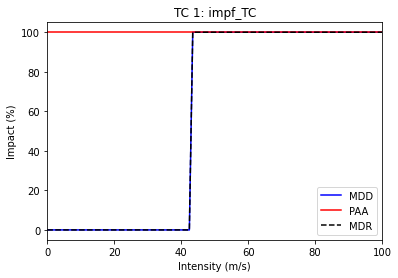

In [26]:
imp_fun.plot() # this is a "vulnerbility function", in this case it would mean that a 40m/s all is destroyed

In [27]:
from climada.engine import Impact

#here is how we calculate an impact. 
impact_TC = Impact()
exposures.gdf['impf_TC'] = 1
exposures.gdf['value'] = 1 # we define the value of our exposures as 1, usually we would here have a monetary value
impact_TC.calc(exposures,imp_fun_set,tc_hist,save_mat=True)
      

2022-09-27 09:55:21,453 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2022-09-27 09:55:25,384 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 93 coordinates.


In [28]:
impact_gdf_tc = impact_TC._build_exp().gdf 
impact_gdf_tc['impact ratio'] = impact_gdf_tc['value']

<GeoAxesSubplot:title={'center':'Expected annual impact'}>

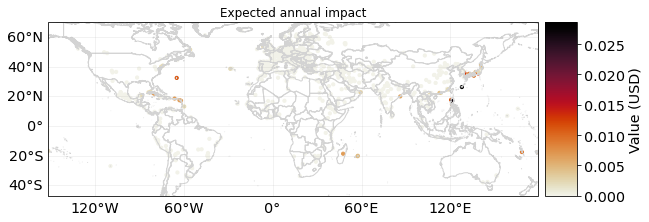

In [29]:
#impact_TC.coord_exp = impact_TC.coord_exp[impact_TC.eai_exp>0.01]
#impact_TC.eai_exp = impact_TC.eai_exp[impact_TC.eai_exp>0.01]

impact_TC.plot_scatter_eai_exposure(s=10, pop_name=False)


In [30]:
impact_gdf_tc = impact_TC._build_exp().gdf 
impact_gdf_tc['impact ratio'] = impact_gdf_tc['value']
impact_gdf_tc

,value,latitude,longitude,impact ratio
0,0.0,34.846940,67.825250,0.0
1,0.0,36.396556,64.516056,0.0
2,0.0,40.074167,20.140833,0.0
3,0.0,39.745732,20.020950,0.0
4,0.0,35.818440,4.786840,0.0
...,...,...,...,...
893,0.0,46.498333,9.846389,0.0
894,0.0,55.274580,20.962390,0.0
895,0.0,49.533889,21.032222,0.0
896,0.0,40.697500,-6.661111,0.0


In [57]:
sites = sites.reset_index(drop=True)

In [32]:
sites['impact ratio tc'] = impact_gdf_tc['impact ratio']

In [33]:
sites[sites['impact ratio tc']>0] # these would be all the sites affected by wind speeds of

,unique_number,id_no,rev_bis,name_en,name_fr,short_description_en,short_description_fr,justification_en,justification_fr,date_inscribed,...,region_en,region_fr,iso_code,udnp_code,transboundary,geometry,centr_TC,impf_TC,value,impact ratio tc
12,2128.0,1511.0,NaN,"Mbanza Kongo, Vestiges of the Capital of the f...","Mbanza Kongo, vestiges de la capitale de l’anc...","<p>The town of Mbanza Kongo, located on a plat...","<p>La cité de Mbanza Kongo, située sur un plat...",NaN,NaN,2017.0,...,Africa,Afrique,ao,ang,0.0,POINT (14.24972 -6.26889),4446214,1,1,0.006652
87,210.0,189.0,NaN,Historic Centre of the Town of Olinda,Centre historique de la ville d'Olinda,<p>Founded in the 16th century by the Portugue...,<p>La ville a été fondée au XVIe siècle par le...,NaN,NaN,1982.0,...,Latin America and the Caribbean,Amérique latine et Caraïbes,br,bra,0.0,POINT (-34.84500 -8.01333),4503229,1,1,0.002217
137,1828.0,1404.0,NaN,Landscape of Grand Pré,Le Paysage de Grand-Pré,<p>Situated in the southern Minas Basin of Nov...,<p>Le &laquo;&nbsp;marais&nbsp;&raquo; de Gran...,"<p align=""left"">The Landscape of Grand Pr&eacu...",NaN,2012.0,...,Europe and North America,Europe et Amérique du Nord,ca,can,0.0,POINT (-64.30722 45.11833),2515375,1,1,0.002217
153,510.0,439.0,Bis,Imperial Palaces of the Ming and Qing Dynastie...,Palais impériaux des dynasties Ming et Qing à ...,<p>Seat of supreme power for over five centuri...,<p>Siège du pouvoir suprême pendant plus de ci...,<p><em>Criterion (i):</em> The Imperial Palace...,<p><em>Critère (i) :</em> Les Palais impériaux...,1987.0,...,Asia and the Pacific,Asie et Pacifique,cn,chn,0.0,POINT (123.44694 41.79417),5832098,1,1,0.002217
154,511.0,440.0,NaN,Mogao Caves,Grottes de Mogao,<p>Situated at a strategic point along the Sil...,<p>Situées en un point stratégique de la Route...,NaN,NaN,1987.0,...,Asia and the Pacific,Asie et Pacifique,cn,chn,0.0,POINT (94.81667 40.13333),5880260,1,1,0.006652
155,512.0,441.0,NaN,Mausoleum of the First Qin Emperor,Mausolée du premier empereur Qin,<p>No doubt thousands of statues still remain ...,<p>Sur ce site archéologique qui ne fut découv...,NaN,NaN,1987.0,...,Asia and the Pacific,Asie et Pacifique,cn,chn,0.0,POINT (109.25995 34.38131),6030518,1,1,0.002217
156,521.0,449.0,NaN,Peking Man Site at Zhoukoudian,Site de l'homme de Pékin à Zhoukoudian,"<p>Scientific work at the site, which lies 42 ...","<p>À 42 km au sud-ouest de Pékin, le site, don...",NaN,NaN,1987.0,...,Asia and the Pacific,Asie et Pacifique,cn,chn,0.0,POINT (115.92270 39.68945),5892583,1,1,0.002217
246,1010.0,859.0,Rev,Holy Trinity Column in Olomouc,Colonne de la Sainte Trinité à Olomouc,"<p>This memorial column, erected in the early ...","<p>Cette colonne commémorative, érigée dans le...",<p><em>Criterion (i):</em> The Olomouc Holy Tr...,<p><em>Critère (i) : </em>La colonne de la Sai...,2000.0,...,Europe and North America,Europe et Amérique du Nord,cz,cze,0.0,POINT (17.25046 49.59394),2265207,1,1,0.002217
333,1663.0,1337.0,NaN,Episcopal City of Albi,Cité épiscopale d'Albi,<p>On the banks of the Tarn river in south-wes...,"<p>Situ&eacute;e en bordure du Tarn, la vieill...",NaN,NaN,2010.0,...,Europe and North America,Europe et Amérique du Nord,fr,fra,0.0,POINT (2.14250 43.92833),2577038,1,1,0.005865
388,2266.0,1580.0,NaN,Water Management System of Augsburg,Système de gestion de l’eau d’Augsbourg,<p>The water management system of the city of ...,Le système de gestion de l’eau de la ville d’A...,NaN,NaN,2019.0,...,Europe and North America,Europe et Amérique du Nord,de,deu,0.0,POINT (10.90200 48.36547),2334309,1,1,0.002217
